https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

In [146]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from mlxtend.regressor import StackingCVRegressor, StackingRegressor

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/aleksandr/Desktop/aml/aml_6/4._Ensemble/hw/train.csv')

In [3]:
display(data.head())
display(data.shape)
display(data.columns)
display(data.info())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 81)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

None

**Посмотрим на пропуски**

In [4]:
# Не будет работать если нет пропусков (можно воспользоваться try except)
# Универсальная функция

def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


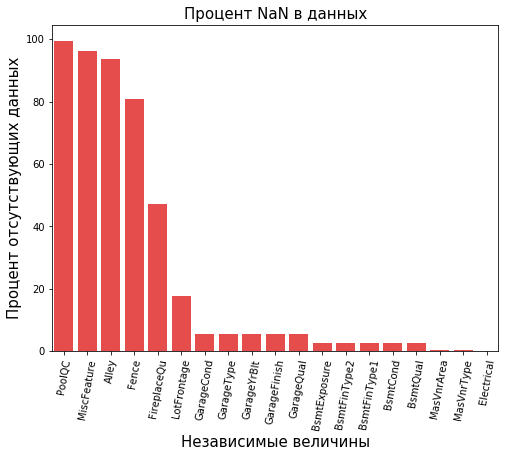

In [5]:
missingdata(data)

In [6]:
all_data = data.copy()

In [7]:
# Все столбцы, в которых пропущенные значения заменены на 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

In [8]:
# Все столбцы, в которых пропущенные значения заменены на 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
            'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

In [9]:
# Все столбцы, в которых пропущенные значения заменены наиболее часто встречающееся значение
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 
            'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [10]:
# LotFrontage со средним (median) значением
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [11]:
# Посмотрим на данные остались ли пустые значения
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':all_data_missing})
missing_data.head(30)

,Missing Ratio


In [12]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

In [43]:
# col = ['MSZoning', 'MSSubClass', 'Street', 'Alley', 'LotShape', 
#        'LandContour', 'Utilities', 'PoolArea', 'PoolQC', 
#        'Fence', 'MiscFeature', 'YrSold', 'SaleType', 'SaleCondition']

# for i in col:
#     print('{} \n'.format(all_data[i].value_counts()))

- Уберем ID в отдельную переменную
- Разобьем на X и y
- Применим get_dummies
- Разобьем ds на X_train y_test 
- Уменьшим размерность, нормализуем данные StandardScaler
- Построим первичную модель RandomForestRegressor
- Посмотрим на важность фичей

In [14]:
t = all_data.copy()
t_id = t['Id']

In [15]:
# Id и SalePrice исключаю из X

X = t[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 
       'Utilities', 'LotConfig','LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']]

y = t['SalePrice']

In [16]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal


In [17]:
X.shape, y.shape

((1460, 79), (1460,))

In [18]:
Xx = pd.get_dummies(X)

In [19]:
Xx.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [20]:
X, X_out, y, y_out = train_test_split(Xx, y.values, test_size=0.2 ,random_state=42)

In [84]:
# sc = StandardScaler().fit(X)

# X_keys = X.columns

# X = sc.transform(X)
# X_out = sc.transform(X_out)

# X = pd.DataFrame(X, columns=X_keys)
# X_out = pd.DataFrame(X_out, columns=X_keys)

In [21]:
X.shape, X_out.shape, y.shape, y_out.shape

((1168, 302), (292, 302), (1168,), (292,))

In [22]:
estimator = RandomForestRegressor(n_estimators=20, max_depth=8, min_samples_leaf=5, max_features=0.5, n_jobs=-1)

param_grid = {
    'n_estimators': [
        1,2,3,4,5,6,7,8,9,10,11,
        12,13,14,15,16,17,18,19,20,
    ], 
    'max_depth': [
        3,4,5,6,7,8
    ]
}

search = GridSearchCV(estimator, param_grid, cv=3)
search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=8, max_features=0.5,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=30, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [1, 2, 3, 4, 5

In [23]:
search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [24]:
search.best_estimator_.score(X, y)

0.9216370880881646

In [25]:
search.best_estimator_.feature_importances_

array([2.79149251e-03, 4.30470616e-03, 2.12989729e-02, 3.72823750e-01,
       2.33197940e-03, 5.51268752e-02, 9.34254080e-03, 3.08471641e-03,
       2.73236938e-02, 1.44747161e-04, 5.01526689e-03, 4.37529008e-02,
       2.95585349e-02, 1.06405764e-02, 0.00000000e+00, 1.66138905e-01,
       2.66184422e-03, 0.00000000e+00, 1.98513937e-02, 7.96012985e-04,
       2.23728190e-03, 7.18885949e-04, 8.01118093e-03, 8.06929921e-03,
       4.03787024e-03, 6.24969724e-02, 2.76018628e-02, 3.06839126e-03,
       3.95914166e-03, 1.19763501e-04, 0.00000000e+00, 5.60818874e-05,
       0.00000000e+00, 0.00000000e+00, 9.31955039e-04, 8.35927424e-04,
       0.00000000e+00, 1.56358709e-05, 0.00000000e+00, 1.18764699e-03,
       7.26830914e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.40264127e-06, 9.31566439e-05, 2.83553054e-04, 0.00000000e+00,
       0.00000000e+00, 1.23107686e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.86167061e-05, 0.00000000e+00, 0.00000000e+00,
      

- сформируем фичи c важностью больше 0.005
- поделим данные на X_train, X_test, y_train, y_test
- инициализируем стекинг
- построим 3 модели (1го уровня и 1 мета модель)
- обучим модели
- предскажим на всех моделях и одной meta модели


- Модели:
    - Модели первого уровня:
        - LinearRegression
        - GradientBoostingRegressor
        - RandomForestRegressor
        - SGDRegressor
    - Модель второго уровня (model_meta_LR):
       - LinearRegression

In [26]:
features = [f for f, i in zip(
    X.columns, search.best_estimator_.feature_importances_) if i > 0.005]

In [27]:
print(features)

['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'ExterQual_TA', 'BsmtQual_Ex']


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=0)

In [109]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((934, 17), (234, 17), (934,), (234,))

In [110]:
X_train.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,ExterQual_TA,BsmtQual_Ex
164,5400,6,1926,2004,370,779,1149,1149,467,1616,2,5,0,1,216,1,0
69,15593,7,1953,1953,603,701,1304,1304,983,2287,2,7,1,2,667,0,0
160,11120,6,1984,1984,660,572,1232,1232,0,1232,2,6,0,2,516,1,0
127,4388,5,1930,1950,116,556,672,840,0,840,1,5,1,0,0,1,0
1288,5664,8,2000,2000,1158,343,1501,1659,0,1659,2,5,1,2,499,0,0


In [111]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [159]:
# model_LR = LinearRegression()
model_ABR = AdaBoostRegressor()
model_BR = BaggingRegressor()
model_GBR = GradientBoostingRegressor()
model_RFR = RandomForestRegressor(n_estimators=27, max_depth=8, min_samples_leaf=5, max_features=0.5, n_jobs=-1)
model_SGDR = SGDRegressor(alpha = 0.01, max_iter = 1000)

model_meta_LR = LinearRegression()

In [160]:
stack = StackingCVRegressor(regressors=(
#     model_LR, 
    model_ABR, 
    model_BR, 
    model_GBR, 
    model_RFR, 
    model_SGDR
),meta_regressor=model_meta_LR,use_features_in_secondary=True)

In [161]:
stack.fit(X_train, y_train)

StackingCVRegressor(cv=5,
                    meta_regressor=LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False),
                    n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
                    refit=True,
                    regressors=(AdaBoostRegressor(base_estimator=None,
                                                  learning_rate=1.0,
                                                  loss='linear',
                                                  n_estimators=50,
                                                  random_state=None),
                                BaggingRegressor(base_estimator=None,
                                                 bootstrap=True...
                                             early_stopping=False, epsilon=0.1,
                                  

In [162]:
def rmse(y_train, y_pred):
     return np.sqrt(mean_squared_error(y_train, y_pred))

def cv_rmse(model, X=X_train, y=y_train):    
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))

kf = KFold(n_splits=10, shuffle=True, random_state=555)

In [164]:
models = {
#     'LinearRegression': model_LR,
    'AdaBoostRegressor': model_ABR,
    'BaggingRegressor': model_BR,
    'GradientBoostingRegressor': model_GBR, 
    'RandomForestRegressor': model_RFR,
    'SGDRegressor': model_SGDR, 
    'StackingCVRegressor_meta_LinearRegression': model_meta_LR
}

predictions = {}
predictions_s = {}

scores = {}
scores_s = {}

for name, model in models.items():
    start = datetime.now()
    print('[{}] Running {}'.format(start, name))
    
    model.fit(X_train, y_train)
    predictions[name] = np.expm1(model.predict(X_train))
    predictions_s[name] = model.predict(X_train)
    
    score = cv_rmse(model, X=X_train, y=y_train)
    scores[name] = (score.mean(), score.std())
    scores_s[name] = (r2_score(y_train, model.predict(X_train)), 
                      explained_variance_score(y_train, model.predict(X_train)))
    
    end = datetime.now()
    
    print('[{}] Finished Running {} in {:.2f}s'.format(end, name, (end - start).total_seconds()))
    print('[{}] {} _score:\n ----- Mean RMSE: {:.6f} / Std: {:.6f} / r2_score: {:.6f} / explained_variance_score: {:.6f}\n'.format(
        datetime.now(), 
        name, 
        scores[name][0], 
        scores[name][1], 
        scores_s[name][0],
        scores_s[name][1]))

print('\n[END]')

[2019-10-26 22:53:14.592676] Running AdaBoostRegressor
[2019-10-26 22:53:15.620432] Finished Running AdaBoostRegressor in 1.03s
[2019-10-26 22:53:15.620613] AdaBoostRegressor _score:
 ----- Mean RMSE: 36054.599625 / Std: 6362.825279 / r2_score: 0.871569 / explained_variance_score: 0.877377

[2019-10-26 22:53:15.620684] Running BaggingRegressor
[2019-10-26 22:53:16.121651] Finished Running BaggingRegressor in 0.50s
[2019-10-26 22:53:16.121798] BaggingRegressor _score:
 ----- Mean RMSE: 33465.556799 / Std: 7598.310151 / r2_score: 0.969358 / explained_variance_score: 0.969374

[2019-10-26 22:53:16.121819] Running GradientBoostingRegressor
[2019-10-26 22:53:16.951572] Finished Running GradientBoostingRegressor in 0.83s
[2019-10-26 22:53:16.951724] GradientBoostingRegressor _score:
 ----- Mean RMSE: 27904.761089 / Std: 6436.839578 / r2_score: 0.962846 / explained_variance_score: 0.962846

[2019-10-26 22:53:16.951770] Running RandomForestRegressor
[2019-10-26 22:53:19.166246] Finished Runnin

In [ ]:
pass